In [1]:
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
import numpy as np
from sklearn.linear_model import Ridge
from sklearn import svm
from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV
from scipy.stats.stats import pearsonr
import seaborn as sns

## Load and transform data

In [19]:
genes = pd.read_csv('norm.tsv', sep='\t', header=0)
labels = pd.read_csv('head.tsv', sep='\t', header=0)

In [22]:
genes['Gene ID'] = genes['Gene ID'] + '_' + genes['DesignElementAccession']

In [12]:
#Rename Columns
disease = labels[["Assay","Factor Value[disease]"]]
disease['Factor Value[disease]'] = disease['Factor Value[disease]'].map({'non-small cell lung cancer': 1, 'normal': 0})

#Transpose and rename
patients = genes.set_index('Gene ID').T
patients = patients.iloc[2:,]
disease.rename(columns={'Assay':'Gene ID'}, inplace=True)
disease.rename(columns={'Factor Value[disease]':'Target'}, inplace=True)

df = disease.join(patients, on='Gene ID')

X = df.iloc[:,2:]
y = df['Target']

C:\Users\pbdon\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\pbdon\Anaconda3\lib\site-packages\pandas\core\frame.py:3778: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


## Feature Selection With LassoCV

In [362]:
clf = LassoCV(cv=5, eps=.0001, n_jobs=4)

sfm = SelectFromModel(clf, threshold=0.01 )
sfm.fit(X, y)
n_features = sfm.transform(X).shape[1]


In [366]:
#Narrow down to n features
n = 5
while n_features > n:
    sfm.threshold += 0.001
    X_transform = sfm.transform(X)
    n_features = X_transform.shape[1]

In [367]:
feature_idx = sfm.get_support()
feature_name = X.columns[feature_idx]
feature_name_target = feature_name.insert(len(feature_name), 'Target')

In [368]:
feature_name

Index(['ENSG00000060718_37892_at', 'ENSG00000103460_216623_x_at',
       'ENSG00000131747_201291_s_at', 'ENSG00000137857_219597_s_at',
       'ENSG00000168952_230560_at'],
      dtype='object')

In [369]:
columns = ['Gene','Min', 'Max', 'Mean', 'STD', 'Correlation']
summary_df = pd.DataFrame(columns=columns)

for gene in feature_name:
    summary_df.loc[len(summary_df)] = [gene, min(df[gene]), max(df[gene]), np.mean(df[gene]), np.std(df[gene]), pearsonr(df[gene], df['Target'])[0]]
    
summary_df    

,Gene,Min,Max,Mean,STD,Correlation
0,ENSG00000060718_37892_at,3.239348,12.152978,6.078783,2.800409,0.835357
1,ENSG00000103460_216623_x_at,3.110577,9.663699,5.061611,1.759446,0.391563
2,ENSG00000131747_201291_s_at,3.435965,10.605294,6.409440,2.461035,0.946912
3,ENSG00000137857_219597_s_at,3.711038,9.698440,7.179656,1.530614,-0.826896
4,ENSG00000168952_230560_at,3.118872,10.152108,6.323180,2.124783,-0.854754


In [370]:
tempdf = df.copy()
tempdf['Target'] = tempdf['Target'].map({1:'non-small cell lung cancer', 0:'normal'})



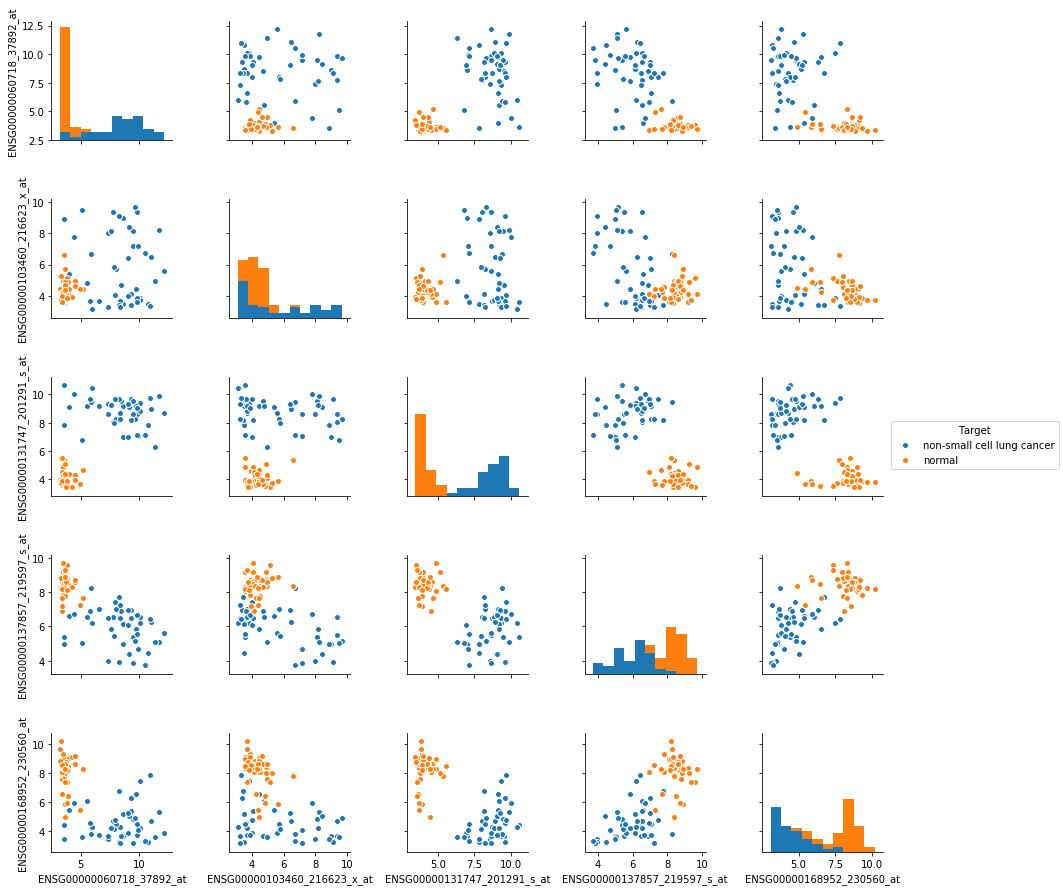

In [360]:


g = sns.pairplot(tempdf[feature_name_target], hue = 'Target')
g.savefig("pairplot2.png")

#If you want only the first triangular half
#for i, j in zip(*np.triu_indices_from(g.axes, 1)):
#    g.axes[i, j].set_visible(False)

## Train/Test Split (Just selected features)

In [299]:
X_train, X_test, y_train, y_test = train_test_split(X[feature_name], y, test_size=0.3)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(63, 5) (63,)
(28, 5) (28,)


## SVC

In [300]:
clf = svm.SVC(kernel='linear', C = 1.0)

model = clf.fit(X_train, y_train)
predictions = clf.predict(X_test)

In [301]:
model

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [302]:
model.score(X_test, y_test)

1.0

## KNN

In [434]:
neigh = KNeighborsClassifier(n_neighbors=9)
model = neigh.fit(X_train, y_train)
predictions = neigh.predict(X_test)

In [435]:
print(model.score(X_test, y_test))

1.0


## Logistic Regression

In [371]:
clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')
model = clf.fit(X_train, y_train)

model.score(X_test, y_test)

1.0

In [ ]:
model.predict_proba(X_test)[:,1]

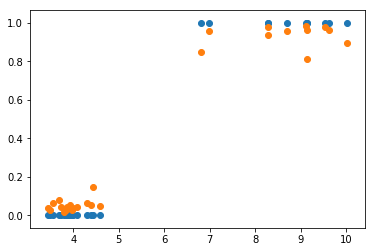

In [407]:
plt.scatter(X_test['ENSG00000131747_201291_s_at'], y_test)
plt.scatter(X_test['ENSG00000131747_201291_s_at'], model.predict_proba(X_test)[:,1])

## PCA (All Features -> 2)

In [452]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(df.iloc[:,2:])

In [453]:
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

In [454]:
finalDf = pd.concat([principalDf, df[['Target']]], axis = 1)
finalDf.head()

,principal component 1,principal component 2,Target
0,98.308399,-26.617084,1
1,-72.442055,-10.225578,0
2,117.642228,-31.722397,1
3,-57.503245,-3.546132,0
4,-10.368728,55.084039,1


In [461]:
pca.explained_variance_ratio_  
finalDf['Target'] = finalDf['Target'].map({1:'non-small cell lung cancer', 0:'normal'})

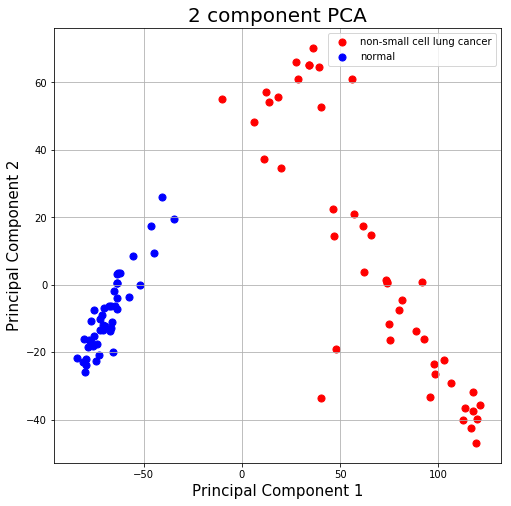

In [463]:

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)

targets = ["non-small cell lung cancer", 'normal']
colors = ['r', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['Target'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [444]:
X_train, X_test, y_train, y_test = train_test_split(finalDf.iloc[:,0:2], finalDf['Target'], test_size=0.3)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(63, 2) (63,)
(28, 2) (28,)


In [446]:
clf = svm.SVC(kernel='linear', C = 1.0)

model = clf.fit(X_train, y_train)
predictions = clf.predict(X_test)

In [447]:
model.score(X_test, y_test)

1.0

In [448]:
neigh = KNeighborsClassifier(n_neighbors=9)
model = neigh.fit(X_train, y_train)
predictions = neigh.predict(X_test)

In [449]:
print(model.score(X_test, y_test))

1.0
